# Table of contents:

* 1\. [The data](#data)<br>
* 2\. [Objectives](#obj)<br>
    * 2.1. [Predict current infected](#obj_predcur)<br>
    * 2.2. [Predict deceased](#obj_preddece)<br>
    * 2.3. [How well can the LSTM model the problem?](#obj_gener)<br>
    * 2.4. [How does the LSTM perform when compared with other models?](#obj_comp)<br>
* 3\. [Time series analysis](#time)<br>
    * 3.2. [Present the data](#time_data)<br>
    * 3.3. [Why stationary?](#time_station)<br>
    * 3.4. [ADF and KPSS tests](#time_tests)<br>
    * 3.5. [Making the time series stationary](#time_transf)<br>
         * 3.4.1. [Differencing](#time_transf_diff)<br>
         * 3.4.2. [Gaussian Curve](#time_transf_gauss)<br>
* 4\. [Preparing the data for the Neural Network](#prep)<br>
    * 4.1. [Train and test](#prep_traintest)<br>
    * 4.2. [Supervised learning](#prep_super)<br>
* 5\. [The LSTM](#lstm)<br>
    * 5.1. [Input, hidden and output layers](#lstm_layers)<br>
    * 5.2. [Training the model](#lstm_train)<br>
    * 5.3. [Does differencing make a difference?](#lstm_diff)<br>
    * 5.4. [Results on global data](#lstm_global)<br>
    * 5.5. [Can it generalize?](#lstm_gener)<br>
* 6\. [The GRU](#gru)<br>
    * 6.1. [Input, hidden and output layers](#gru_layers)<br>
    * 6.2. [Training the model](#gru_train)<br>
    * 6.3. [Results on global data](#gru_global)<br>
* 7\. [Summary of results](#summary)<br>
    * 7.1. [Plot predictions of all algorithms over the original data](#summary_global)<br>
    * 7.2. [Summarize findings](#summary_findings)

In [65]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Reduces tensorflow messages.

In [66]:
import warnings
warnings.filterwarnings('ignore')  # Reduces warning messages.

In [67]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout
from keras.callbacks.callbacks import EarlyStopping

In [68]:
import data_handler  # Custom module used to fetch and prepare data from GitHub.

In [69]:
import pandas as pd
import numpy as np

In [70]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss

In [71]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]  # Adjust plot sizes.

Function to help plot data.

In [72]:
def plot_data(data_to_plot, title, legend, x_label, y_label, adjust_xaxis=True):
    fig, ax = plt.subplots()
    for dataset in data_to_plot:
        ax.plot(dataset)
    ax.set_title(title)
    ax.legend(legend, loc='best')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    # Prevent the x-axis labels from overlapping.
    if adjust_xaxis:
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, 4))
        fig.autofmt_xdate()

# 1. The data <a name="data"></a>

Before any analysis can be done it is important to understand the data we will be working with. The data comes from the<br>
[Johns Hopkins University GitHub repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). This data set provides three time series; the total infected, recovered and deceased.

This function fetches the data from the GitHub repository, if necessary, and returns a list of dataframes with each time series.

In [73]:
raw_data = data_handler.load_data()

Here is how the data looks like in table format.

In [74]:
raw_data[0].head()  # Confirmed.

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,736,750,766,773,782,789,795,803,820,832
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,743,743,743,745,745,747,748,750,751,751
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,27,27,27,27,30,35,35,35,36,36


In [75]:
raw_data[1].head()  # Deceased.

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,57,58,60,64,68,72,85,90,95,104
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,28,30,30,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,432,437,444,450,453,459,463,465,470,476
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,40,41,42,42,43,44,45,45,46,46
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [76]:
raw_data[2].head()  # Recovered.

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,220,228,252,260,310,331,345,397,421,458
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,422,431,455,470,488,519,531,543,570,595
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1558,1651,1702,1779,1821,1872,1936,1998,2067,2197
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,385,398,423,468,468,472,493,499,514,521
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,6,6,7,7,11,11,11,11,11,11


It is also possible to view the data for a specific country.

In [77]:
raw_data[0][raw_data[0]['Country/Region'].isin(['United Kingdom'])]  # Total confirmed cases in the UK.

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
217,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,0,0,0,...,110,110,111,114,114,114,115,115,115,118
218,Cayman Islands,United Kingdom,19.3133,-81.2546,0,0,0,0,0,0,...,70,70,73,73,74,74,74,75,78,78
219,Channel Islands,United Kingdom,49.3723,-2.3644,0,0,0,0,0,0,...,525,530,537,537,538,543,544,544,545,545
220,Gibraltar,United Kingdom,36.1408,-5.3536,0,0,0,0,0,0,...,141,141,141,144,144,144,144,144,144,144
221,Isle of Man,United Kingdom,54.2361,-4.5481,0,0,0,0,0,0,...,308,309,313,315,316,320,321,325,326,327
222,Montserrat,United Kingdom,16.7425,-62.1874,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,157149,161145,165221,171253,177454,182260,186599,190584,194990,201101
249,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
250,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,7
251,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,...,12,12,12,12,12,12,12,12,12,12


The following formula can be used to find the number of current infected as oposed to total infected (confirmed cases):<br>
current infected = total infected - (deceased + recovered)

In [78]:
current_infected = data_handler.calculate_current_infected(raw_data)

Plotting the data hepls to visualise it better. But first all rows must be summed up into one time series.

In [79]:
confirmed = raw_data[0].sum()[2:]  # The first two rows are the sums of Long and Lat which must be removed.
deceased = raw_data[1].sum()[2:]
recovered = raw_data[2].sum()[2:]

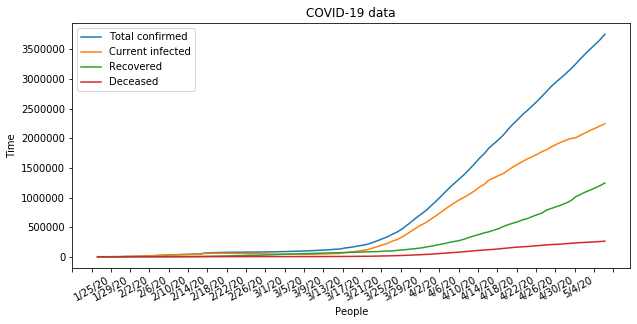

In [80]:
plot_data([confirmed, current_infected, recovered, deceased], 'COVID-19 data', ['Total confirmed', 'Current infected',
    'Recovered', 'Deceased'], 'People', 'Time')

# 2. Objectives <a name="obj"></a>

The Kaggle competition requires two forecasts to be made, the number of infected people and the number of deceased people.<br>
There are two more objectives proposed in this notebook. One, how well do the machine learning models perform when compared with<br>
eachother? Two, how good is the LSTM at generalizing the problem of forecasting the COVID-19?

## 2.1 The Kaggle compettition <a name="obj_kaggle"></a>

Now that the data has been explained, it is possible to use any time series forecasting method on it. In this notebook the<br>
selected methods where the LSTM and GRU.

## 2.3 How well can the LSTM model COVID-19? <a name="obj_gener"></a>

To prove that the LSTM has actualy learnt from the data it is necessary to create forecasts on unseen data. A testing<br>
set is usualy separated from the data before using the rest to train a neural network. But how well can the network model the<br>
virus? This can be verified by using the same model trained on the global data and using it to make predictions on individual<br>
countries. Technicaly the global data contains all the information present in each individual country. This will demonstrate if<br>
the model has actualy learnt how the number of inferted people change over time.

The following code prepares the data for a plot demonstrating the above pagraph.

In [81]:
def get_country_data(country):
    data = []
    # Total confirmed cases in the country.
    data.append(raw_data[0][raw_data[0]['Country/Region'].isin([country])])
    # Total deceased cases in the country.
    data.append(raw_data[1][raw_data[1]['Country/Region'].isin([country])])
    # Total recovered cases in the country.
    data.append(raw_data[2][raw_data[2]['Country/Region'].isin([country])])
    # Make the deceased table into a time series.
    deceased = data[1].sum(numeric_only=True)[2:]
    # Calculate time series of infected people.
    infected = data_handler.calculate_current_infected(data)
    return deceased, infected

In [82]:
uk_deceased, uk_infected = get_country_data('United Kingdom')
# Split UK infected.
uk_inf_train, uk_inf_test = data_handler.split_train_test(uk_infected, 0.7)
# Split UK deceased.
uk_dec_train, uk_dec_test = data_handler.split_train_test(uk_deceased, 0.7)
# Split global infected.
global_inf_train, global_inf_test = data_handler.split_train_test(current_infected, 0.7)

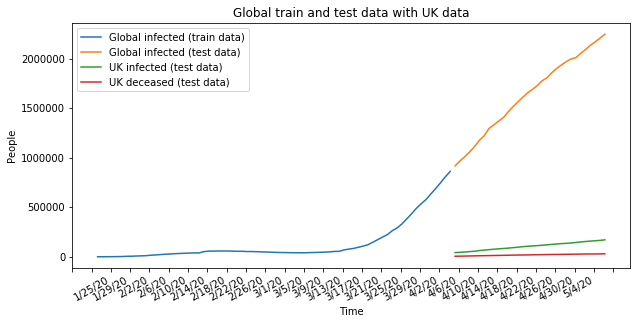

In [83]:
plot_data([global_inf_train, global_inf_test, uk_inf_test, uk_dec_test], 'Global train and test data with UK data', ['Global infected (train data)', 'Global infected (test data)', 'UK infected (test data)', 'UK deceased (test data)'], 'Time', 'People')

Is a model trined on the global infected (blue line) capable of creating accurate forecasts for the UK data? A comparisson<br>
between a models trained on the global infected data and a model designed for this compettition was made in Chapter X.

## 2.4 How does the LSTM perform when compared with other models? <a name="obj_comp"></a>

RMSE, allong with the RMSLE, was used to compare the performance for the models. Plots were also used to show how the selected<br>
models perform on the data. MASE was used to calculate the accuracy of forecasts. As this uses percentages it is possible to<br>
compare different methods quite well.<br>
The three loss functions used to compare the models performance are:

### 2.4.1 Root Mean Squared Error (RMSE):<br>
Calculates the average error in the forecasts. Values calculated by this function represent the number of people the forecast<br>
got wrong.

$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(p_i-r_i)^2} $<br>
Where *p* is the predicted value, *r* is the real value and *n* is the number of data.

In [84]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

### 2.4.2 Root Mean Squared Log Error (RMSLE):<br>
Other than being chosen by Kaggle, this loss function penalises predictions smaller than the real value. So, according to this<br>
function, overestimating the number of infected people is better than underestimating it.

$ RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\ln(p_i+1)-\ln(r_i+1))^2} $<br>
Where *p* is the predicted value, *r* is the real value and *n* is the number of data.

In [85]:
def rmsle(prediction, target):
    return np.sqrt(((np.log(prediction+1) - np.log(target+1)) ** 2).mean())

### 2.4.3 Mean Absolure Scaled Error (MASE):<br>
This represents the forecast error as a ratio. This is usefull as it allows forecasts on different scales to be compared.

$ MASE = \frac{\frac{1}{J}\sum_{j}|p_i-r_i|}{\frac{1}{T-1}\sum_{t=2}^{T}|r_t-r_{t-1}|}  $<br>
Where *p* is the predicted value, *r* is the real value , *T* is the size of the training set, *J* is the number of forecats.

In [86]:
def mase(prediction, target, train_size):
    mean_error = (abs(prediction - target)).mean()
    scaling_factor = (1/(train_size-1)) * target.diff().abs().sum()
    return float(mean_error / scaling_factor)

# 3. Time series analysis <a name="time"></a>

In this chapter an analysis of the time series was performed. This analysis will highlight features in the data which cause the<br>
time series to have trends. A time series with a trend is called non-stationary because the mean (average) changes over time.<br>
Once these trends are found they can be removed from the data making it a stationary time series.

## 3.1 Why stationary? <a name="time_station"></a>

To create accurate forecasts the time series must be stationary simplly because it is easier to model data without any trends.<br>
There are two statistical tests that can be applied to a time series to check whether it is stationary or not. This is better<br>
than simply 'looking' at the data as it can find (and prove the existence of) useful features in the series.

The plot of the current infected shows a clear trend in the data.

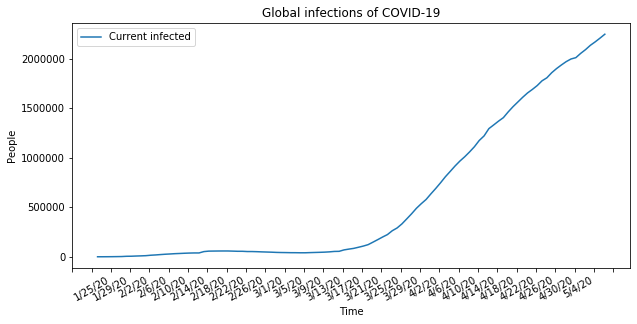

In [87]:
plot_data([current_infected], 'Global infections of COVID-19', ['Current infected'], 'Time', 'People')

## 3.2 ADF and KPSS tests <a name="time_tests"></a>

These functions help print out the results from the following tests.

In [88]:
def print_results(res, index, row_names):
    formatted_res = pd.Series(res[0:index], index=row_names)
    for key, value in res[index].items():
        formatted_res[f'Critical Value ({key})'] = value
    print(formatted_res)

In [89]:
def print_adf(results):
    print("Results for the ADF test:")
    print_results(results, 4, ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

### 3.2.1 The Augmented Dickey Fuller (ADF) test.

* The null hypothesis for the ADF test is that the time series is not stationary because it has a unit root.<br>
* The alternate hypothesis is that there is no unit root in the data making it stationary.<br>
* The unit root is a feature in a time  series that causes a trend. This can be removed by differencing the data.<br>
* The null hypothesis is assumed to be true until it is proven to be false, i.e. it is assumed that the data is not stationary by default.<br>
* To reject the null hypothesis (prove there is no trend) the p-value produced by the test must be less than the Critical Value.<br>
* The Critical Value represents how certain the test is of its results, e.g. if the p-value is lest than 0.05 (5%) then we can say that the test is 95% confident that the time series is stationary.

In [90]:
adf_results = adfuller(current_infected)
print_adf(adf_results)

Results for the ADF test:
Test Statistic                  2.547671
p-value                         0.999064
Lags Used                      12.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


As the p-value is larger than all levels of alpha (0.01, 0.05 and 0.1) this means that the time series has a unit root. In fact<br>
it is possible to multiply the p-value by 100 to see how confident the test is. For example a p-value of 0.973938 means that the<br>
test is 97% confident that the is a unit root (trend) in the data.

### 3.2.2 The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

* The KPSS test complements the ADF test.<br>
* Its null hypothesis states that the time series is stationary.<br>
* While there alternate hypothesis states that the data has a unit root.<br>
* The p-value and the Critical Values work the same ass the ADF test.<br>
* However, if the null hypothesis is not rejected, the KPSS shows that the data is 'trend' stationary. This means that it is stationary around a deterministic trend.<br>
* For example, a linear trend is present where all values increase over time. If this trend is removed the data will become stationary.

In [91]:
kpss_results = kpss(current_infected, nlags='auto')
print("Results for the KPSS test:")
print_results(kpss_results, 3, ['Test Statistic', 'p-value', 'Lags Used'])

Results for the KPSS test:
Test Statistic           1.349822
p-value                  0.010000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/marcus/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


The results show that the null hypothesis is rejected, this means that the unit root is definitely present and that there is no deterministic trend.

Note: the results will be different every time more data is added to the series.

## 3.4 Making the time series stationary <a name="time_transf"></a>

The tests show there is at least one unit root in the data. This can be removed by differencing the data. As there is no<br>
deterministic trend in the data there is no need to use the KPSS test again. Another important factor is the range the data is<br>
in. If the neural network is given large numbers to process, e.g. between 10000 and 50000, it will take too long to train it.<br>
This range must be 'squashed' into a more  manageable range. However, the method used to transform the data must make it fit in<br>
a Gaussian curve as it makes data data easier to forecast.

### 3.4.1 Differencing <a name="time_transf_diff"></a>

Differencing takes the difference between each point in the data. The result of this is a series showing the change in the data.<br>
Example: The fist row shows the number of infected people while the second (differenced) row shows the change in infected<br>
people. This proces removes the unit root from the data and can be repeated as many times as necessary.

In [92]:
orig = current_infected.head()
orig.columns = ['Original']
diff = current_infected.head().diff()
diff.columns = ['Differenced']
pd.concat([orig.T, diff.T])

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20
Original,510.0,606.0,879.0,1353.0,2010.0
Differenced,NaN,96.0,273.0,474.0,657.0


It is important to note that every time the data is differenced some level of detail is lost. This can be verified by the NaN<br>
value in the second row.

Now that differencing has been explained it can be applied on the full dataset. The graph now shows the global rate of<br>
infection.

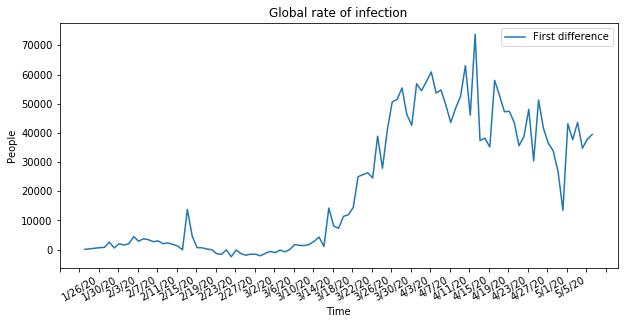

In [93]:
first_differenced = current_infected.diff().dropna()
plot_data([first_differenced], 'Global rate of infection', ['First difference'], 'Time', 'People')

Another ADF test on the differenced data shows that there is still a unit root in the data. This means that the data must be differenced again.

In [94]:
adf_results = adfuller(first_differenced)
print_adf(adf_results)

Results for the ADF test:
Test Statistic                 -1.814905
p-value                         0.373087
Lags Used                      11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


Differencing the data a second time shows us that even though the graph looks like a stationary time series there still is an unit root in the data as the p-value is greater than all alpha values.

Results for the ADF test:
Test Statistic                 -2.211270
p-value                         0.202180
Lags Used                      13.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


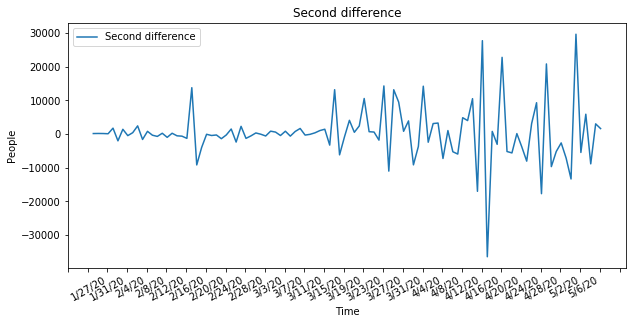

In [95]:
second_differenced = first_differenced.diff().dropna()
plot_data([second_differenced], 'Second difference', ['Second difference'], 'Time', 'People')
adf_results = adfuller(second_differenced)
print_adf(adf_results)

When differenced a third time the data shows us that there are no more unit roots. The p-value has become so small that there is almost a 100% certainty of it.

Results for the ADF test:
Test Statistic                 -2.219884
p-value                         0.199108
Lags Used                      12.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


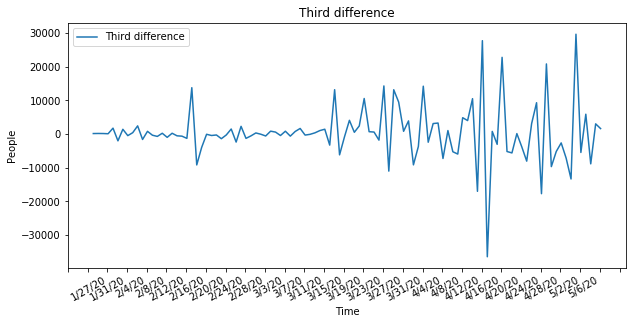

In [96]:
third_differenced = second_differenced.diff().dropna()
plot_data([second_differenced], 'Third difference', ['Third difference'], 'Time', 'People')
adf_results = adfuller(third_differenced)
print_adf(adf_results)

### 3.4.2 Gaussian Curve <a name="time_transf_gauss"></a>

It is desirable that the data fits a Gaussian curve as it is easier to model it. The shape of this dataset can be seen by plotting it as a histogram. It is possible to see that the original data has a long right tail. This means that there a many 'rare values' greater than the mean (average). This makes sense when looking back at the original plot where the curve stays horizontal for a while before the number of infected people start to rise.

On the other hand, the data after being differenced three times looks more like a Gaussian distribution (the bell shape). This is because the trends where removed.

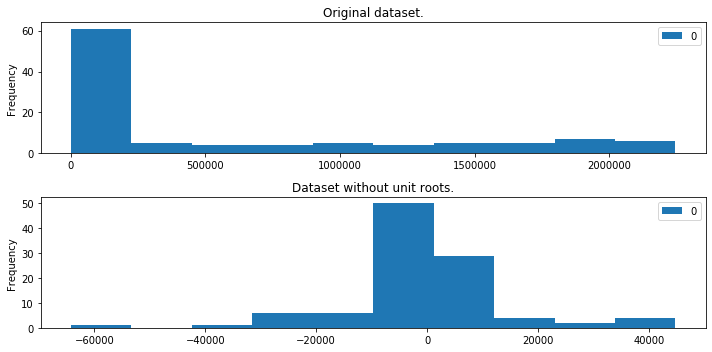

In [97]:
fig, ax = plt.subplots(2, 1)
current_infected.plot(kind='hist', ax=ax[0])
ax[0].set_title("Original dataset.")
third_differenced.plot(kind='hist', ax=ax[1])
ax[1].set_title("Dataset without unit roots.")
fig.tight_layout()

#### 3.4.2.1 The BoxCox methods

In [98]:
one_d_ci = [i[0] for i in current_infected.values]  # The boxcox methods require 1 dimensional data.

In [99]:
data1 = boxcox(one_d_ci, -1)    # reciprocal transform.
data2 = boxcox(one_d_ci, -0.5)  # reciprocal square root transform.
data3 = boxcox(one_d_ci, 0)     # log transform.
data4 = boxcox(one_d_ci, 0.5)   # square root transform.

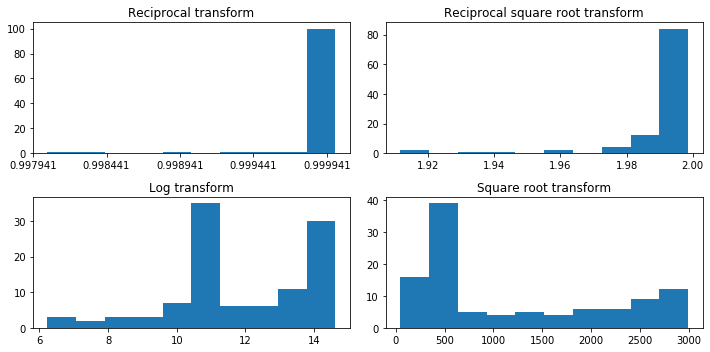

In [100]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].hist(data1)
axes[0, 0].set_title('Reciprocal transform')
start, end = axes[0, 0].get_xlim()  # Prevents the labels on the x-axis from overlapping.
axes[0, 0].xaxis.set_ticks(np.arange(start, end, 0.00050))
axes[0, 1].hist(data2)
axes[0, 1].set_title('Reciprocal square root transform')
axes[1, 0].hist(data3)
axes[1, 0].set_title('Log transform')
axes[1, 1].hist(data4)
axes[1, 1].set_title('Square root transform')
fig.tight_layout()

From the graphs above it is possible to see that the method that makes the data look more like a Gaussian distribution is the<br>
log transform. This can be used on the data to 'squash' the values before giving it to the neural network. This is important<br>
because it would take longer to process the larger numbers. Taking the log of the data will reduce training time without<br>
drastically affecting the structure of the data.

Note that the these transformations where applied to the original data before the differencing.

# 4. Preparing the data for the Neural Network <a name="prep"></a>

## 4.1 Train and test <a name="prep_traintest"></a>

The neural networks used in this experiment are the LSTM (a type of RNN) and the GRU (a simplified LSTM). These were chosen as<br>
they were designed to handle sequence data like a time series.

In [101]:
forecast_horizon = 4   # Number of observations to be used to predict the next event.
train_set_ratio = 0.7  # The size of the training set as a percentage of the data set.

Split the data into train and test sets. This must be done before any transformations to avoid data leakage. Otherwise there might be information about the test set in the train set because of the data transformation applied.<br>
Note: the transformations done before where for the analysis of the time series, now they will be used to actually reshape the data.

In [102]:
train, test = data_handler.split_train_test(current_infected, train_set_ratio)

This helps visualize the train and test data.

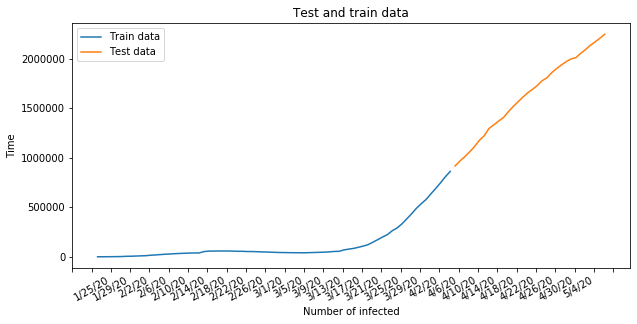

In [103]:
plot_data([train, test], 'Test and train data', ['Train data', 'Test data'], 'Number of infected', 'Time')

Make the time series data stationary based on what we found before.

In [104]:
train_log, train_diff_one, train_diff_two, stationary_train = data_handler.adjust_data(train)
test_log, test_diff_one, test_diff_two, stationary_test = data_handler.adjust_data(test)

## 4.2 Supervised learning <a name="prep_super"></a>

Transform the data into a supervised learning dataset. Essentially the neural network will use a number of observations<br>
(forecast horizon) to predict the next event in the sequence, e.g. use four days of data to predict the fifth.

In [105]:
supervised_train = data_handler.series_to_supervised(stationary_train, 0, forecast_horizon)
supervised_test = data_handler.series_to_supervised(stationary_test, 0, forecast_horizon)

Create sets for input and output based on the forecast horizon.

In [106]:
x_train, y_train = data_handler.split_horizon(supervised_train, forecast_horizon)
x_test, y_test = data_handler.split_horizon(supervised_test, forecast_horizon)

This part is required by the Keras models as they take 3 dimensional input.<br>
Reshape x from [samples, time steps] to [samples, time steps, features]<br>
Where samples = rows and time steps = columns.

In [107]:
features = 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], features)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], features)

# 5. The LSTM <a name="lstm"></a>

## The hyperparameters

A standard sequential model. One layer after the other.

In [108]:
lstm_model = Sequential()

## 5.1 Input, hidden and output layers <a name="lstm_layers"></a>

### 5.1.1 The input layer.

The LSTM receives the input as an array of size equals to the forecast horizon where each item is an array of size one.<br>
e.g. [[1], [2], [3], [4]]

In [109]:
input_layer = (forecast_horizon, 1)

### 5.1.2 The hidden layer.

In [110]:
nodes = 5  #  The number of nodes in the hidden layer represents how 'wide' the network will be.
lstm_model.add(LSTM(nodes, input_shape=input_layer))

In [111]:
lstm_activation = "relu"  # The activation function decides how much information flows though the nodes.
lstm_model.add(Activation(lstm_activation))

The dropout function selects nodes at random and uses them during one training epoch (iteration). This is applied for each training epoch.<br>
his helps reduce overfitting by making the nodes learn the data instead of relying on other nodes.

In [112]:
rate = 0.1 # The probability of a node being ignored during training, e.g. 10%.
lstm_model.add(Dropout(rate))

### 5.1.3 The output layer.

In [113]:
out_shape = 1  # The number of outputs the LSTM will produce. Technically the number of nodes in the dense layer.
# It is possible to output the forecasts for the next few days but in this model only one value will be produced.
lstm_model.add(Dense(out_shape))

In [114]:
dense_activation = "sigmoid"  # The activation function for the output node works the same as for the hidden layer.
lstm_model.add(Activation(dense_activation))

## 5.2 Training the model <a name="lstm_train"></a>

Here the model is told how to learn. The objective of the optimizer is to make the output of the loss function smaller.

In [115]:
loss = "mean_squared_error"
opti = "adam"
lstm_model.compile(loss=loss, optimizer=opti)

This will stop the training if the loss does not change for 50 consecutive epochs.

In [116]:
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

Here the model is trained. As this was framed as a supervised learning task the LSTM will try to match the input (x_train) to<br>
the output (y_train). One input will pass through the LSTM at a time (batch_size) until all inputs are processed. This will be<br>
done 1000 times (epochs) and in each iteration the network will (hopefully) 'learn' a little more. One fifth of the training<br>
data (0.2) is left out as a validation set for each epoch.

In [117]:
lstm_history = lstm_model.fit(x_train, y_train, epochs=1000, batch_size=1, verbose=0, callbacks=[early_stopping],
        validation_split=0.2)

## 5.3 A model for the competition <a name="lstm_diff"></a>

#### The submission file for the competition was generated by this model.

In [118]:
multi_data = pd.concat([confirmed, deceased], axis=1)
multi_train, multi_test = data_handler.split_train_test(multi_data, train_set_ratio)

In [119]:
print(multi_data.shape)
print(multi_train.shape)
print(multi_test.shape)

(106, 2)
(74, 2)
(32, 2)


In [120]:
multi_train_log, multi_train_diff_one, multi_train_diff_two, stationary_multi_train = data_handler.adjust_data(multi_train)
multi_test_log, multi_test_diff_one, multi_test_diff_two, stationary_multi_test = data_handler.adjust_data(multi_test)

In [121]:
print(stationary_multi_train.shape)
print(stationary_multi_test.shape)

(71, 2)
(29, 2)


In [122]:
x_multi_train, y_multi_train = data_handler.multivariate_to_supervised(stationary_multi_train, forecast_horizon)
x_multi_test, y_multi_test = data_handler.multivariate_to_supervised(stationary_multi_test, forecast_horizon)

In [123]:
print(x_multi_train.shape)
print(y_multi_train.shape)
print(x_multi_test.shape)
print(y_multi_test.shape)

(67, 4, 2)
(67, 2)
(25, 4, 2)
(25, 2)


In [124]:
feature_n = 2  # Number of features = number of time series (infected and deceased).
#x_multi_train = x_multi_train.reshape(x_multi_train.shape[0], x_multi_train.shape[1], feature_n)
#x_multi_test = x_multi_test.reshape(x_multi_test.shape[0], x_multi_test.shape[1], feature_n)

In [125]:
#print(x_multi_train.shape)
#print(x_multi_test.shape)

In [126]:
print(x_multi_train)
#print(x_multi_test)

[[[-1.42252457e-01 -1.98718066e-01]
  [-8.87194700e-02 -3.03739308e-01]
  [-3.52233679e-02  2.85576492e-01]
  [ 3.87845265e-01 -6.57496467e-03]]

 [[-8.87194700e-02 -3.03739308e-01]
  [-3.52233679e-02  2.85576492e-01]
  [ 3.87845265e-01 -6.57496467e-03]
  [-8.65978762e-01 -5.40436790e-01]]

 [[-3.52233679e-02  2.85576492e-01]
  [ 3.87845265e-01 -6.57496467e-03]
  [-8.65978762e-01 -5.40436790e-01]
  [ 7.33633795e-01  6.89488894e-01]]

 [[ 3.87845265e-01 -6.57496467e-03]
  [-8.65978762e-01 -5.40436790e-01]
  [ 7.33633795e-01  6.89488894e-01]
  [-2.91236753e-01 -2.67848442e-01]]

 [[-8.65978762e-01 -5.40436790e-01]
  [ 7.33633795e-01  6.89488894e-01]
  [-2.91236753e-01 -2.67848442e-01]
  [ 1.08058801e-01  7.59310586e-03]]

 [[ 7.33633795e-01  6.89488894e-01]
  [-2.91236753e-01 -2.67848442e-01]
  [ 1.08058801e-01  7.59310586e-03]
  [ 1.33902867e-01  1.63372967e-01]]

 [[-2.91236753e-01 -2.67848442e-01]
  [ 1.08058801e-01  7.59310586e-03]
  [ 1.33902867e-01  1.63372967e-01]
  [-3.03103208e-

In [127]:
#print(y_multi_train.shape)
#print(y_multi_test.shape)

In [128]:
print(y_multi_train)
#print(y_multi_test)

[[-8.65978762e-01 -5.40436790e-01]
 [ 7.33633795e-01  6.89488894e-01]
 [-2.91236753e-01 -2.67848442e-01]
 [ 1.08058801e-01  7.59310586e-03]
 [ 1.33902867e-01  1.63372967e-01]
 [-3.03103208e-01 -3.11301270e-01]
 [ 1.77996188e-01  1.53265251e-01]
 [-5.28592113e-02  1.12919290e-02]
 [ 9.37132788e-04 -1.21169968e-02]
 [ 3.95408858e-02  2.83985324e-02]
 [-3.63522867e-02 -2.04077188e-02]
 [ 3.62195576e-02  1.43231972e-02]
 [-1.75446419e-02 -8.05654408e-03]
 [-9.85378701e-04 -1.21659858e-02]
 [-2.08696303e-02 -7.21711934e-02]
 [ 3.16882907e-01  2.89177268e-01]
 [-4.65970802e-01 -2.98374076e-01]
 [ 1.15432921e-01  8.34591490e-02]
 [ 7.06712791e-02 -1.37912635e-02]
 [-2.85321246e-03  2.25242574e-02]
 [ 2.85762012e-04  2.45491464e-02]
 [-1.57948605e-02 -3.39386964e-02]
 [ 1.93179796e-02  1.75737423e-02]
 [ 1.01994661e-04 -5.69773669e-02]
 [ 1.36536380e-02  1.41653265e-01]
 [-3.20962158e-02 -1.69703130e-01]
 [ 2.03700267e-02  1.41833386e-01]
 [ 2.49525854e-04 -9.15086622e-02]
 [-1.38255522e-03  2

In [129]:
competition_model = Sequential()
competition_model.add(LSTM(50, return_sequences=True, input_shape=(forecast_horizon, feature_n)))
competition_model.add(Activation("relu"))
competition_model.add(Dropout(0.1))
competition_model.add(LSTM(50))
competition_model.add(Activation("relu"))
competition_model.add(Dropout(0.1))
competition_model.add(Dense(feature_n))
competition_model.add(Activation("relu"))
competition_model.compile(loss="mean_squared_error", optimizer="adam")
competition_history = competition_model.fit(x_multi_train, y_multi_train, epochs=1000, batch_size=1, verbose=0,
                                            callbacks=[early_stopping], validation_split=0.2)

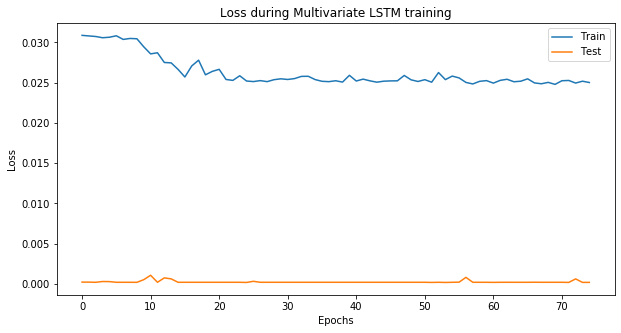

In [130]:
plot_data([competition_history.history['loss'], competition_history.history['val_loss']], 'Loss during Multivariate LSTM training', ['Train', 'Test'], 'Epochs', 'Loss', adjust_xaxis=False)

In [131]:
multi_train_prediction = competition_model.predict(x_multi_train)
multi_test_prediction = competition_model.predict(x_multi_test)

Rescale predictions.

In [132]:
print(multi_train_prediction)
print(multi_test_prediction)

[[0.         0.        ]
 [0.68672544 0.        ]
 [0.         0.        ]
 [0.1413259  0.        ]
 [0.03096078 0.        ]
 [0.         0.        ]
 [0.24641065 0.        ]
 [0.         0.        ]
 [0.00181118 0.        ]
 [0.02360287 0.        ]
 [0.         0.        ]
 [0.00794176 0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.00590499 0.        ]
 [0.03021447 0.        ]
 [0.         0.        ]
 [0.24444214 0.        ]
 [0.02991431 0.        ]
 [0.         0.        ]
 [0.02340296 0.        ]
 [0.         0.        ]
 [0.00254579 0.        ]
 [0.         0.        ]
 [0.01226528 0.        ]
 [0.         0.        ]
 [0.0371757  0.        ]
 [0.         0.        ]
 [0.00473325 0.        ]
 [0.00816854 0.        ]
 [0.         0.        ]
 [0.00146138 0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.00184738 0.        ]


In [133]:
scaled_multi_train_predictions = data_handler.rescale_data(multi_train_prediction,
        multi_train_diff_one[0],
        multi_train_diff_two[0],
        multi_train_log[0],
        forecast_horizon)
scaled_multi_test_predictions = data_handler.rescale_data(multi_test_prediction,
        multi_test_diff_one[0],
        multi_test_diff_two[0],
        multi_test_log[0],
        forecast_horizon)

Rescale the answers.

In [134]:
scaled_multi_train = data_handler.rescale_data(y_multi_train,
        multi_train_diff_one[0],
        multi_train_diff_two[0],
        multi_train_log[0],
        forecast_horizon)
scaled_multi_test = data_handler.rescale_data(y_multi_test,
        multi_test_diff_one[0],
        multi_test_diff_two[0],
        multi_test_log[0],
        forecast_horizon)

In [135]:
competition_multi_train_rmse = rmse(scaled_multi_train, scaled_multi_train_predictions)
competition_multi_test_rmse = rmse(scaled_multi_test, scaled_multi_test_predictions)
competition_multi_train_rmsle = rmsle(scaled_multi_train, scaled_multi_train_predictions)
competition_multi_test_rmsle = rmsle(scaled_multi_test, scaled_multi_test_predictions)

## 5.4 Results on global data <a name="lstm_global"></a>

Make the predictions. The predictions on the training data are only used to measure the model's performance as it should have<br>
already learnt it.

In [136]:
train_prediction = lstm_model.predict(x_train)
test_prediction = lstm_model.predict(x_test)

Rescale predictions.

In [137]:
scaled_train_predictions = data_handler.rescale_data(train_prediction,
        train_diff_one[0],
        train_diff_two[0],
        train_log[0],
        forecast_horizon)
scaled_test_predictions = data_handler.rescale_data(test_prediction,
        test_diff_one[0],
        test_diff_two[0],
        test_log[0],
        forecast_horizon)

Rescale the answers.

In [138]:
scaled_train = data_handler.rescale_data(y_train,
        train_diff_one[0],
        train_diff_two[0],
        train_log[0],
        forecast_horizon)
scaled_test = data_handler.rescale_data(y_test,
        test_diff_one[0],
        test_diff_two[0],
        test_log[0],
        forecast_horizon)

Calculate the error values.

In [139]:
lstm_train_rmse = rmse(scaled_train, scaled_train_predictions)
lstm_test_rmse = rmse(scaled_test, scaled_test_predictions)
lstm_train_rmsle = rmsle(scaled_train, scaled_train_predictions)
lstm_test_rmsle = rmsle(scaled_test, scaled_test_predictions)

Plot model loss history.

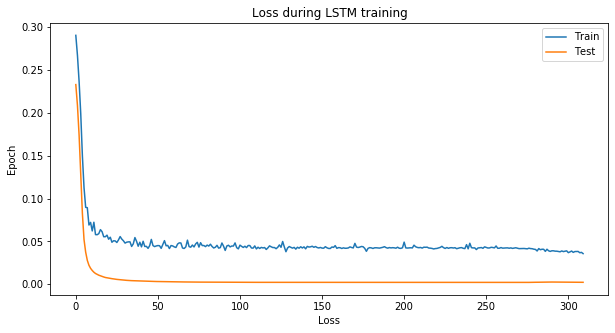

In [140]:
plot_data([lstm_history.history['loss'], lstm_history.history['val_loss']], 'Loss during LSTM training', ['Train', 'Test'], 'Loss', 'Epoch', adjust_xaxis=False)

Some preparation to plot the predictions is needed.

The first sample is lost after each differencing, so the + 2 is required.

In [141]:
empty_arr = np.empty((forecast_horizon+2, 1))
empty_arr[:] = np.nan
shifted_train = np.concatenate([empty_arr, scaled_train_predictions])
# The test data mus be shifted by 2 empty arrays plus the training data.
empty_arr = np.empty(((forecast_horizon+2)*2+len(scaled_train_predictions), 1))
empty_arr[:] = np.nan
shifted_test = np.concatenate([empty_arr, scaled_test_predictions])

Plot the predictions over the original dataset.

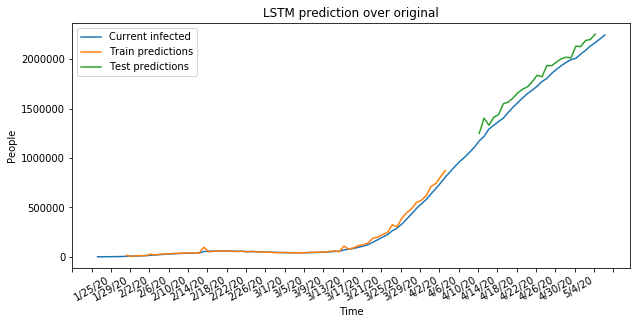

In [142]:
plot_data([current_infected, shifted_train, shifted_test], 'LSTM prediction over original', ['Current infected', 'Train predictions', 'Test predictions'], 'Time', 'People', 'Number of infected')

## 5.5 Can it generalize? <a name="lstm_gener"></a>

In this chapter the LSTM trained on the global data is tested on data from individual countries. This will determine how well<br>
the model can generalize the COVID-19 data.

The data must be prepared in the same way as the global infected data. This function provides a more generic approach to the<br>
whole task of preparing the data and making the predictions.

In [143]:
def make_lstm_predictions(data):
    _, test = data_handler.split_train_test(data, train_set_ratio)
    log, diff_one, diff_two, stationary = data_handler.adjust_data(test)
    supervised = data_handler.series_to_supervised(stationary, 0, forecast_horizon)
    x, y = data_handler.split_horizon(supervised, forecast_horizon)
    x = x.reshape(x.shape[0], x.shape[1], features)
    predictions = lstm_model.predict(x)
    scaled_predictions = data_handler.rescale_data(predictions, diff_one[0], diff_two[0], log[0], forecast_horizon)
    scaled_answers = data_handler.rescale_data(y, diff_one[0], diff_two[0], log[0], forecast_horizon)
    return scaled_predictions, scaled_answers 

#### Global.

In [144]:
global_infected_pred, global_infected_real = make_lstm_predictions(confirmed)
global_deceased_pred, global_deceased_real = make_lstm_predictions(deceased)

#### UK.

In [145]:
uk_deceased, uk_infected = get_country_data("United Kingdom")
uk_infected_pred, uk_infected_real = make_lstm_predictions(uk_infected)
uk_deceased_pred, uk_deceased_real = make_lstm_predictions(uk_deceased)

#### USA.

In [146]:
us_deceased, us_infected = get_country_data("US")
us_infected_pred, us_infected_real = make_lstm_predictions(us_infected)
us_deceased_pred, us_deceased_real = make_lstm_predictions(us_deceased)

#### China.

In [147]:
china_deceased, china_infected = get_country_data("China")
china_infected_pred, china_infected_real = make_lstm_predictions(china_infected)
china_deceased_pred, china_deceased_real  = make_lstm_predictions(china_deceased)

The results

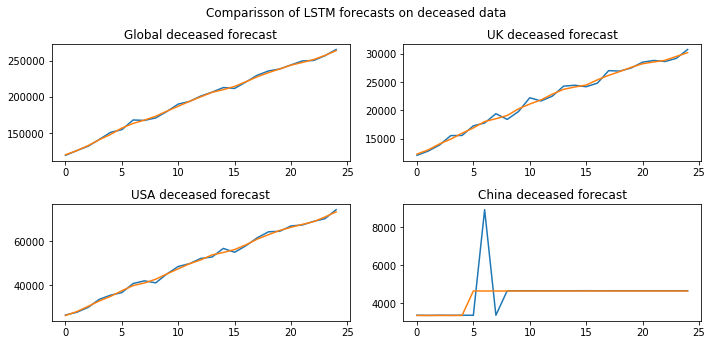

In [148]:
fig, axes = plt.subplots(2, 2)
fig.suptitle("Comparisson of LSTM forecasts on deceased data")
axes[0, 0].plot(global_deceased_pred)
axes[0, 0].plot(global_deceased_real)
axes[0, 0].set_title('Global deceased forecast')
axes[0, 1].plot(uk_deceased_pred)
axes[0, 1].plot(uk_deceased_real)
axes[0, 1].set_title('UK deceased forecast')
axes[1, 0].plot(us_deceased_pred)
axes[1, 0].plot(us_deceased_real)
axes[1, 0].set_title('USA deceased forecast')
axes[1, 1].plot(china_deceased_pred)
axes[1, 1].plot(china_deceased_real)
axes[1, 1].set_title('China deceased forecast')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

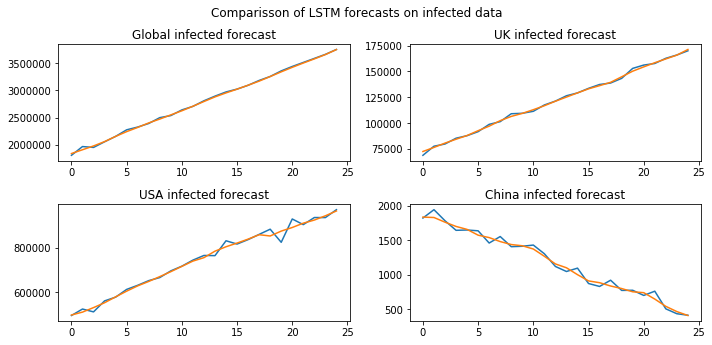

In [149]:
fig, axes = plt.subplots(2, 2)
fig.suptitle("Comparisson of LSTM forecasts on infected data")
axes[0, 0].plot(global_infected_pred)
axes[0, 0].plot(global_infected_real)
axes[0, 0].set_title('Global infected forecast')
axes[0, 1].plot(uk_infected_pred)
axes[0, 1].plot(uk_infected_real)
axes[0, 1].set_title('UK infected forecast')
axes[1, 0].plot(us_infected_pred)
axes[1, 0].plot(us_infected_real)
axes[1, 0].set_title('USA infected forecast')
axes[1, 1].plot(china_infected_pred)
axes[1, 1].plot(china_infected_real)
axes[1, 1].set_title('China infected forecast')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 6. The GRU <a name="gru"></a>

The GRU is a simplified and modern version of the LSTM. Because the code in this chapter is essencialy the same as the LSTM,<br>
less explanations were provided.

In [150]:
gru_model = Sequential()

## 6.1 Input, hidden and output layers <a name="gru_layers"></a>

### 6.1.1 The input layer.

In [151]:
gru_input_layer = (forecast_horizon, 1)

### 6.1.2 The hidden layer.

In [152]:
gru_nodes = 5
gru_model.add(GRU(gru_nodes, input_shape=gru_input_layer))

In [153]:
gru_activation = "relu"
gru_model.add(Activation(gru_activation))

In [154]:
gru_rate = 0.1
gru_model.add(Dropout(gru_rate))

### 6.1.3 The output layer.

In [155]:
gru_out_shape = 1
gru_model.add(Dense(gru_out_shape))

In [156]:
gru_dense_activation = "sigmoid"
gru_model.add(Activation(gru_dense_activation))

## 6.2 Training the model <a name="gru_train"></a>

In [157]:
gru_loss = "mean_squared_error"
gru_opti = "adam"
gru_model.compile(loss=gru_loss, optimizer=gru_opti)

The early stopping callbak is the same as the one used in the LSTM.

In [158]:
gru_history = gru_model.fit(x_train, y_train, epochs=1000, batch_size=1, verbose=0, callbacks=[early_stopping],
        validation_split=0.2)

## 6.3 Results on global data <a name="gru_global"></a>

In [159]:
gru_train_prediction = gru_model.predict(x_train)
gru_test_prediction = gru_model.predict(x_test)

In [160]:
gru_scaled_train_predictions = data_handler.rescale_data(gru_train_prediction,
        train_diff_one[0],
        train_diff_two[0],
        train_log[0],
        forecast_horizon)
gru_scaled_test_predictions = data_handler.rescale_data(gru_test_prediction,
        test_diff_one[0],
        test_diff_two[0],
        test_log[0],
        forecast_horizon)

In [161]:
gru_scaled_train = data_handler.rescale_data(y_train,
        train_diff_one[0],
        train_diff_two[0],
        train_log[0],
        forecast_horizon)
gru_scaled_test = data_handler.rescale_data(y_test,
        test_diff_one[0],
        test_diff_two[0],
        test_log[0],
        forecast_horizon)

In [162]:
gru_train_rmse = rmse(gru_scaled_train, gru_scaled_train_predictions)
gru_test_rmse = rmse(gru_scaled_test, gru_scaled_test_predictions)
gru_train_rmsle = rmsle(gru_scaled_train, gru_scaled_train_predictions)
gru_test_rmsle = rmsle(gru_scaled_test, gru_scaled_test_predictions)

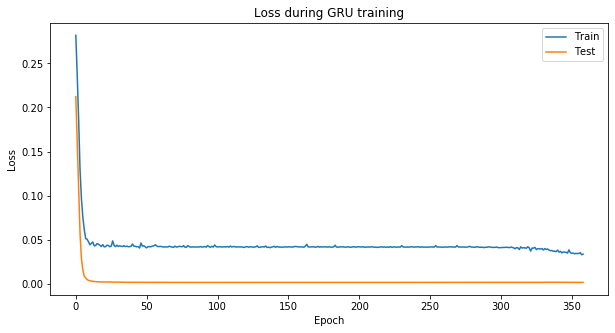

In [167]:
plot_data([gru_history.history['loss'], gru_history.history['val_loss']], 'Loss during GRU training', ['Train', 'Test'], 'Epoch', 'Loss',
        adjust_xaxis=False)

In [164]:
empty_arr = np.empty((forecast_horizon+2, 1))
empty_arr[:] = np.nan
shifted_train = np.concatenate([empty_arr, gru_scaled_train_predictions])
# The test data mus be shifted by 2 empty arrays plus the training data.
empty_arr = np.empty(((forecast_horizon+2)*2+len(gru_scaled_train_predictions), 1))
empty_arr[:] = np.nan
shifted_test = np.concatenate([empty_arr, gru_scaled_test_predictions])

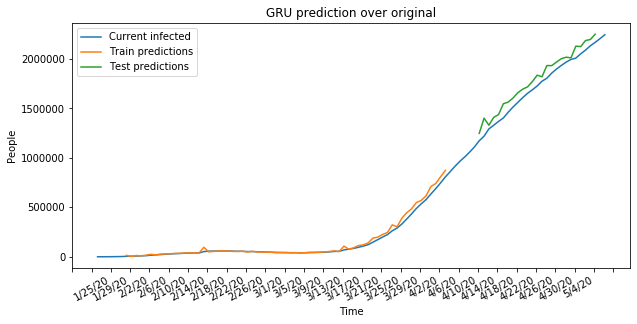

In [165]:
plot_data([current_infected, shifted_train, shifted_test], 'GRU prediction over original',  ['Current infected', 'Train predictions', 'Test predictions'], 'Time', 'People', 'Number of infected')

# 7. Summary of results <a name="summary"></a>

LSTM results.

In [166]:
print(f"RMSE on train: {lstm_train_rmse}")
print(f"RMSE on test: {lstm_test_rmse}")
print(f"RMSLE on train: {lstm_train_rmsle}")
print(f"RMSLE on test: {lstm_test_rmsle}")
# GRU results.
print(f"RMSE on train: {gru_train_rmse}")
print(f"RMSE on test: {gru_test_rmse}")
print(f"RMSLE on train: {gru_train_rmsle}")
print(f"RMSLE on test: {gru_test_rmsle}")
# Competition results.
print(f"RMSE on train: {competition_multi_train_rmse}")
print(f"RMSE on test: {competition_multi_test_rmse}")
print(f"RMSLE on train: {competition_multi_train_rmsle}")
print(f"RMSLE on test: {competition_multi_test_rmsle}")

RMSE on train: 10513.124002092134
RMSE on test: 27110.552373614628
RMSLE on train: 0.18340779733600865
RMSLE on test: 0.01746836058290489
RMSE on train: 10442.058512597463
RMSE on test: 26732.36739577141
RMSLE on train: 0.18242222574686132
RMSLE on test: 0.01733481386338913
RMSE on train: 8166.758382529261
RMSE on test: 21536.327372714986
RMSLE on train: 0.14079604731126152
RMSLE on test: 0.009007206357125739


## 7.1 Plot predictions of all algorithms over the original data <a name="summary_global"></a><br>
## 7.2 Summarize findings <a name="summary_findings"></a>